# SnowPetrel

In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from sp_utils import sp_utils, classification, pose_estimation

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from rich import print
import os

In [4]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms

In [5]:
import json

with open('config.json', 'r') as file:
    config = json.load(file)

In [6]:
print(config)

{
    'Task': 'SnowPetrel',
    'engineer': 'Adam-Al-Rahman',
    'date': 'Oct9',
    'project_path': 'SnowPetrel/SnowPetrel-Adam-2024-10-09',
    'engine': 'pytorch',
    'bodyparts': ['head', 'beak_base', 'beak_tip', 'neck', 'body1', 'body2', 'tail_base'],
    'skeleton': [
        ['head', 'beak_base'],
        ['beak_base', 'beak_tip'],
        ['head', 'neck'],
        ['neck', 'body1'],
        ['body1', 'body2'],
        ['body2', 'tail_base']
    ],
    'skeleton_color': 'black',
    'pcutoff': 0.6,
    'dotsize': 4,
    'alphavalue': 0.7,
    'dataset': {'img_width': 320, 'img_height': 240, 'num_keypoints': 7},
    'model': {
        'pose_estimation': {
            'model_file': 
'models/pose_estimation\\sp_pe_resnet50_batch_norm2d_swish_dropout_epochs200_lr1e-05_2024-11-22T09-21.pth',
            'architecture': 'resnet50_batch_norm2d_swish_dropout',
            'epochs': 200,
            'batch_size': 16,
            'learning_rate': 1e-05,
            'optimizer': 'Adam',
            'criterion': 'MSELoss',
            'evaluation_metric': 'PCKh',
            'head_threshold': 0.1,
            'device_like_type': 'cuda'
        },
        'classification': {
            'model_file': 
'models/classification\\sp_cls_gcn_gru_relu_dropout_epochs50_lr0.0001_2024-11-22T22-01.pth',
            'architecture': 'gcn_gru_relu_dropout',
            'labels': ['nesting', 'preening'],
            'hidden_dim': 128,
            'edges': [[0, 1, 0, 3, 4, 5], [1, 2, 3, 4, 5, 6]],
            'epochs': 50,
            'batch_size': 16,
            'learning_rate': 0.0001,
            'optimizer': 'Adam',
            'criterion': 'BCEWithLogitsLoss',
            'evaluation_metric': 'precision_recall_fscore',
            'device_like_type': 'cuda'
        }
    }
}

## Dataset

In [7]:
# DATASET_ROOT = "datasets/test"
DATASET_ROOT = "datasets"
IMG_WIDTH = config["dataset"]["img_width"]
IMG_HEIGHT  = config["dataset"]["img_height"]

# TEST_DATASET_FILE = DATASET_ROOT + "/preprocessed_tdata.csv"
TEST_DATASET_FILE = DATASET_ROOT + "/test_dataset.csv"

test_df = pd.read_csv(TEST_DATASET_FILE)

## PoseEstimation

In [8]:
from sp_utils import PoseDataset, BirdPoseModel

In [9]:
PE_MODEL_FILE = config["model"]["pose_estimation"]["model_file"]
PE_MODEL_NAME = config["model"]["pose_estimation"]["architecture"]
PE_NUM_KEYPOINTS = config["dataset"]["num_keypoints"]
PE_NUM_BATCH = config["model"]["pose_estimation"]["batch_size"]
PE_THRESHOLD = config["model"]["pose_estimation"]["head_threshold"]

DeviceLikeType = config["model"]["pose_estimation"]["device_like_type"]
DEVICE = torch.device(DeviceLikeType)

In [10]:
# Image Transformations Defination
img_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
])

kp_transform = pose_estimation.NormalizeKeypoints(IMG_WIDTH, IMG_HEIGHT)

test_dataset = pose_estimation.PoseDataset(
    dataframe=test_df, 
    dataset_root_folder=DATASET_ROOT, 
    img_transform=img_transform, 
    kp_transform=kp_transform
)

# Create dataloaders
test_loader = DataLoader(test_dataset, batch_size=PE_NUM_BATCH, shuffle=False, num_workers=0, pin_memory=True)

In [11]:

pe_model = pose_estimation.BirdPoseModelX(PE_NUM_KEYPOINTS)
pe_model.load_state_dict(torch.load(PE_MODEL_FILE, map_location=DEVICE, weights_only=True)) 
# model.load_state_dict(torch.load(os.path.join(MODEL_PATH, "sp_pe_resnet50_batch_norm2d_relu_2024-11-19T21-36.pth"), map_location=device, weights_only=True)) 
pe_model.to(DEVICE) 

average_pckh = pose_estimation.pe_accuracy(pe_model, test_loader, DEVICE, PE_THRESHOLD)
print(f"Average PCKh: {average_pckh:.2f}%")

Average PCKh: 73.34%

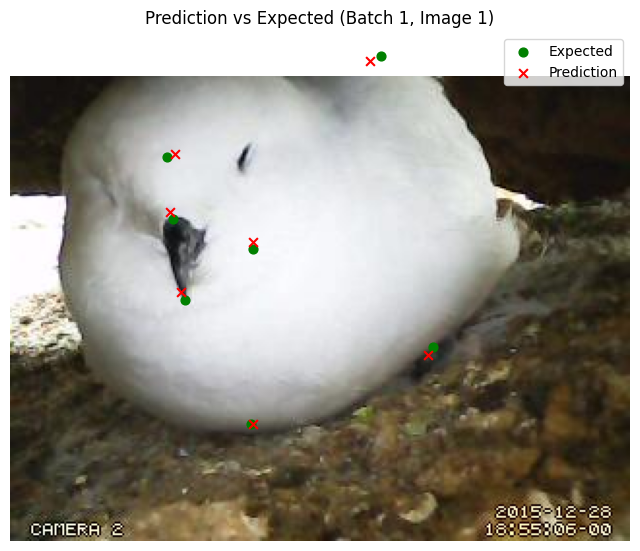

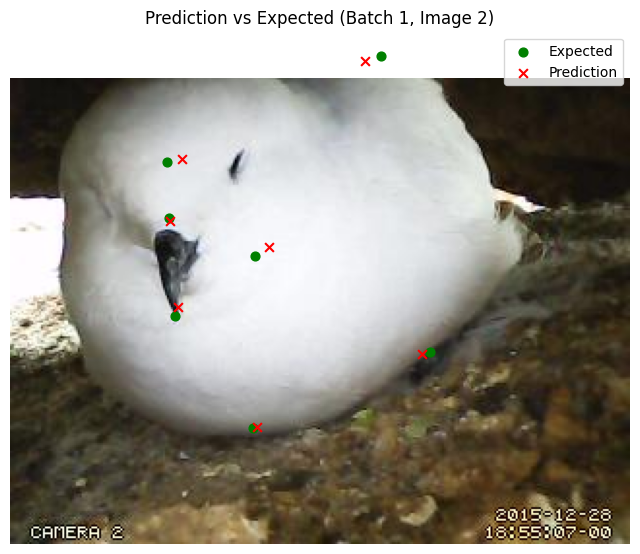

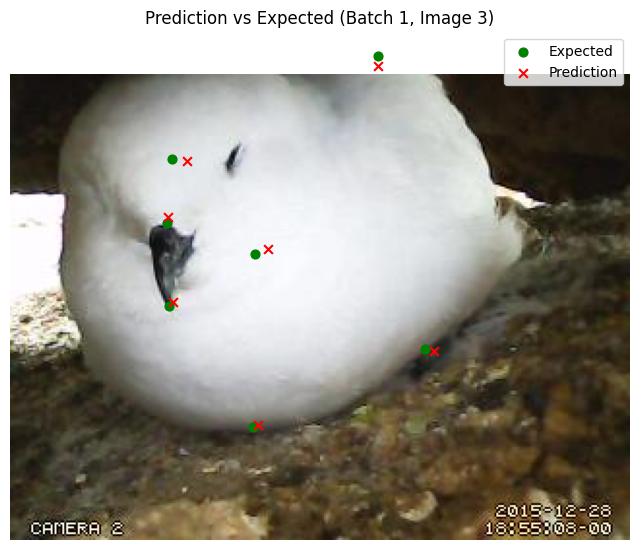

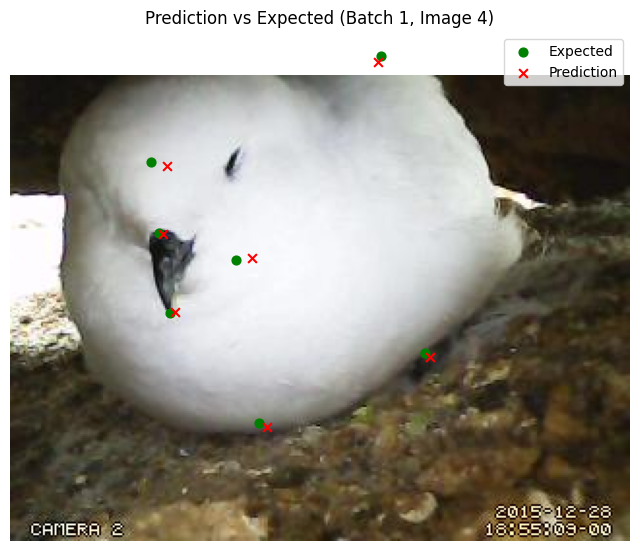

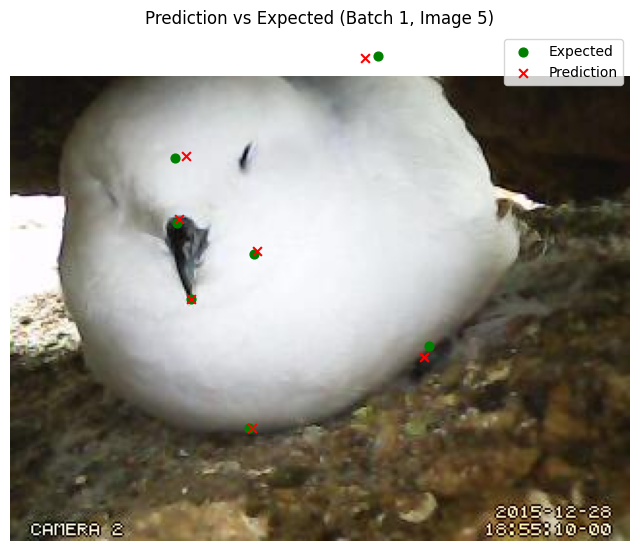

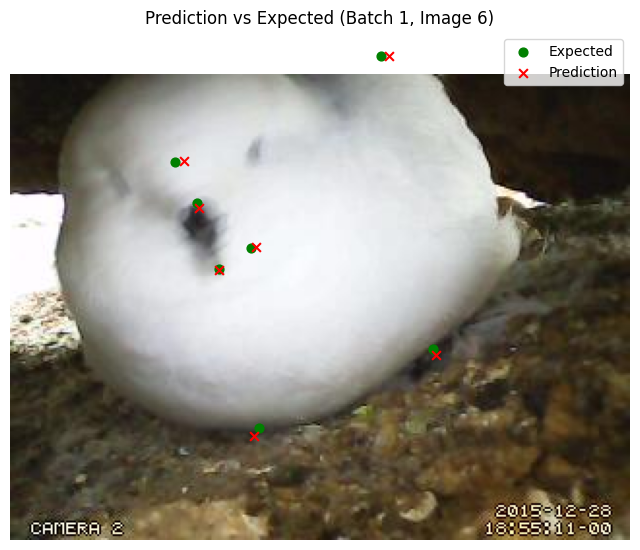

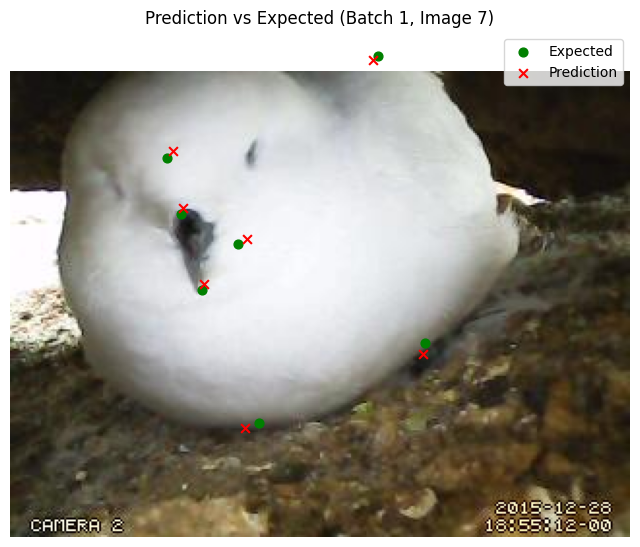

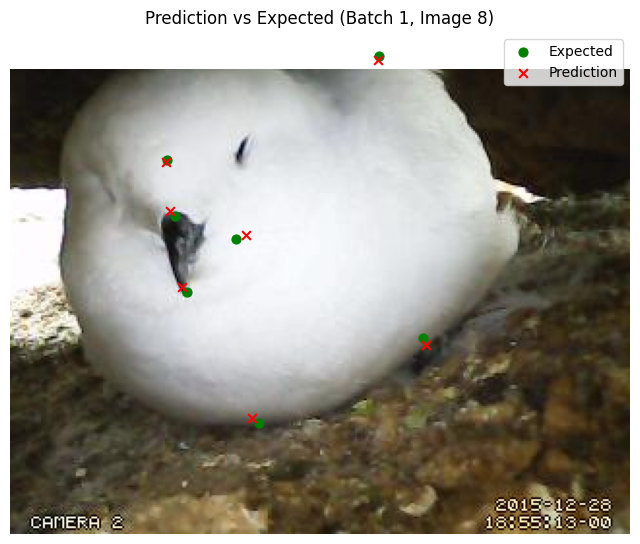

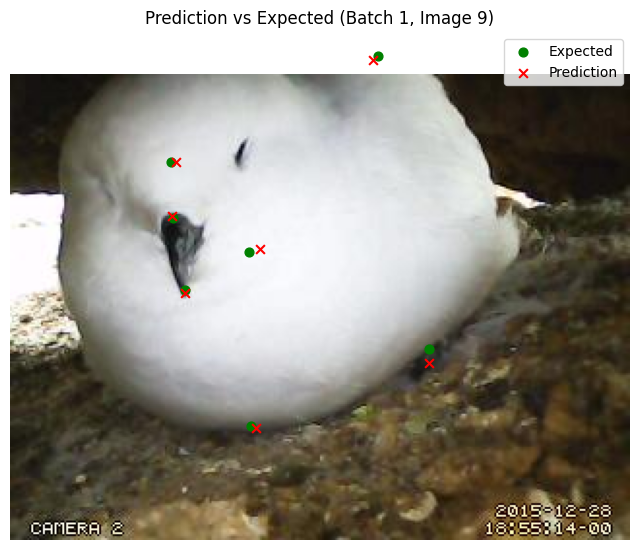

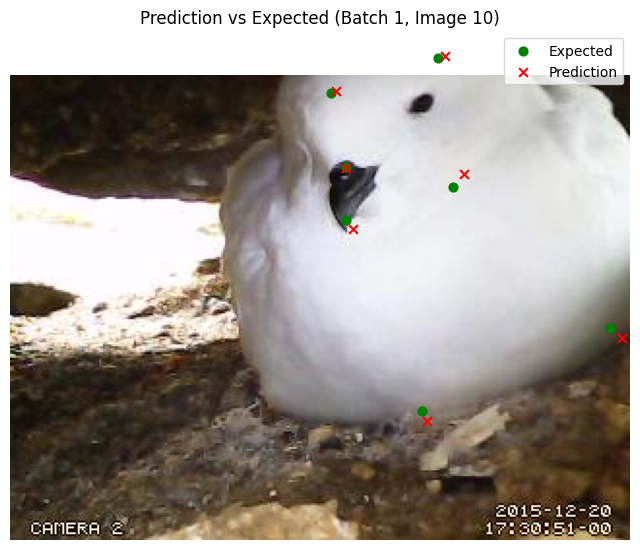

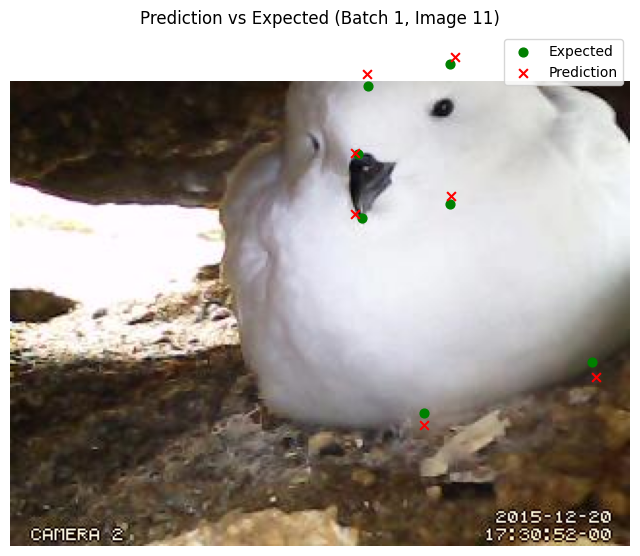

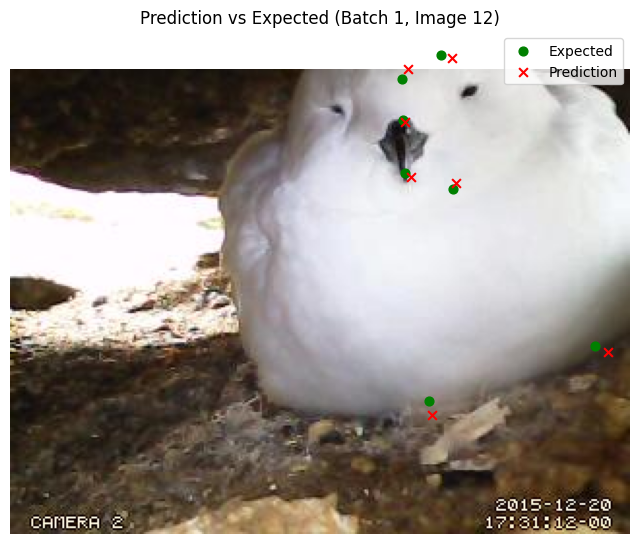

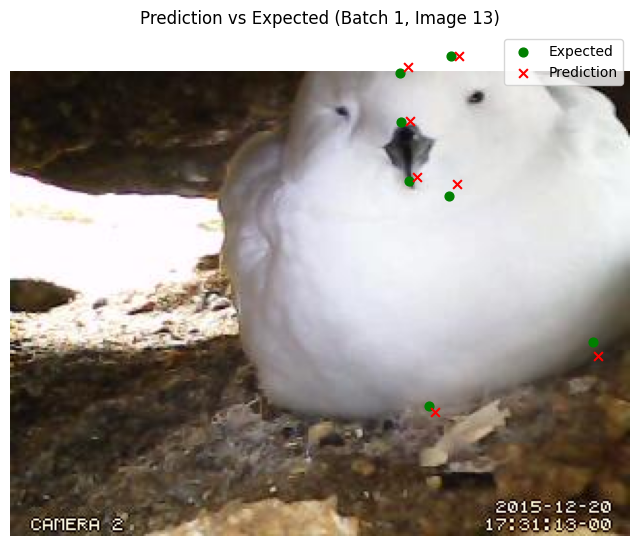

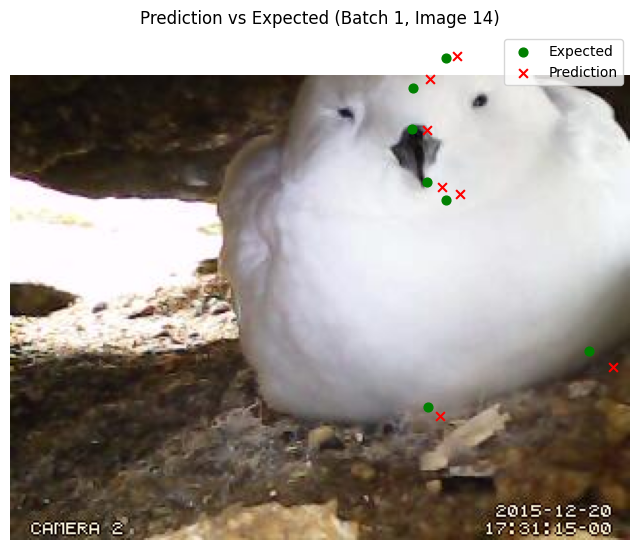

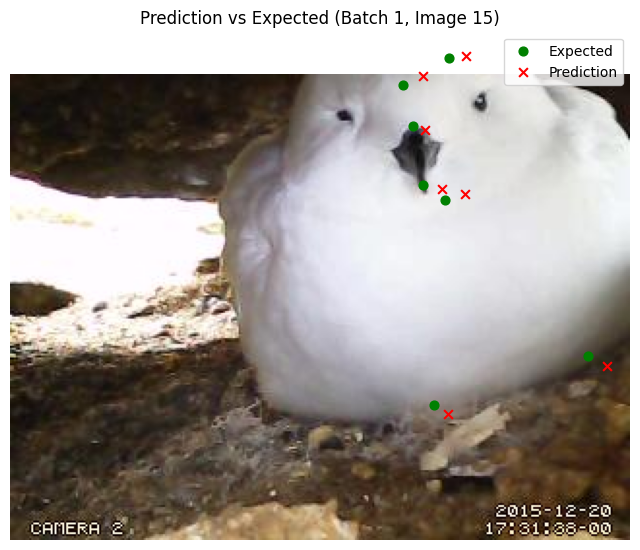

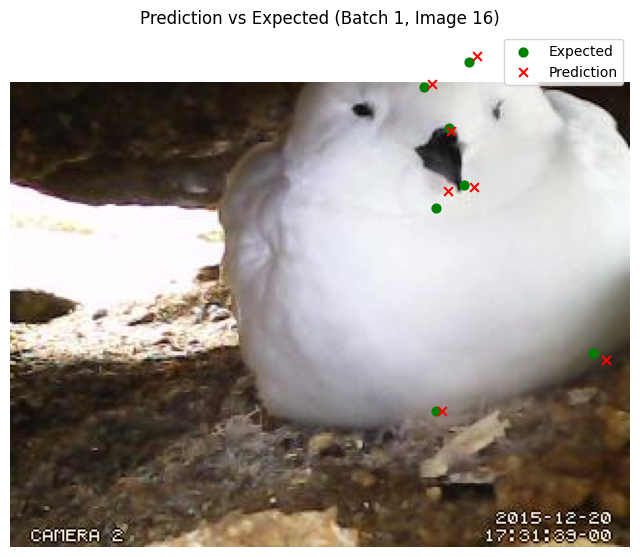

In [12]:
kp_denormalize = pose_estimation.DenormalizeKeypoints(IMG_WIDTH, IMG_HEIGHT)

pe_result = pose_estimation.plot(pe_model, test_loader, DEVICE, kp_denormalize, 1)

In [13]:
kp_prediction  = pose_estimation.result(pe_model, test_loader, DEVICE, kp_denormalize)

In [14]:

headers = ["behavior", "image_id", "image_file", "head_x", "head_y", "beak_base_x", "beak_base_y", 
                  "beak_tip_x", "beak_tip_y", "neck_x", "neck_y", "body1_x", "body1_y", 
                  "body2_x", "body2_y", "tail_base_x", "tail_base_y"]

kp_pred_df = pd.DataFrame(kp_prediction)
kp_pred_df = pd.concat([test_df.iloc[:, :3], kp_pred_df], axis=1)
kp_pred_df.columns = headers

kp_pred_df.to_csv(os.path.join(DATASET_ROOT, f"pe_prediction_{PE_MODEL_NAME}.csv"), index=False)

kp_pred_df

behavior image_id                 image_file      head_x      head_y  \
0           0    n_012   24-20151228185506-00.jpg   84.794151   52.786175   
1           0    n_012   24-20151228185507-00.jpg   66.296707   40.703094   
2           0    n_012   24-20151228185508-00.jpg   90.742233   58.243477   
3           0    n_012   24-20151228185509-00.jpg   60.375996   45.989384   
4           0    n_012   24-20151228185510-00.jpg   90.193741   54.358898   
..        ...      ...                        ...         ...         ...   
107         1    p_017  103-20151221054909-00.jpg  116.583389  115.532021   
108         1    p_017  103-20151221054910-00.jpg  156.944412  179.024750   
109         1    p_017  103-20151221054911-00.jpg  133.291504  130.511993   
110         1    p_017  103-20151221054912-00.jpg  166.114197  217.575836   
111         1    p_017  103-20151221054913-00.jpg  116.877098  117.744431   

     beak_base_x  beak_base_y  beak_tip_x  beak_tip_y      neck_x      neck_y  \
0      82.054146    92.845154   87.926346  147.885483  125.068924  113.736427   
1      61.386608    72.902237   64.695114  117.079781   99.783478   86.348320   
2      81.030899    96.908310   83.733665  155.746140  132.678253  119.048126   
3      58.687668    81.092087   63.327412  121.541931   93.316101   93.238167   
4      86.473877    97.685364   93.076027  152.855255  127.060974  119.785522   
..           ...          ...         ...         ...         ...         ...   
107   147.432816    88.480118  146.676239   75.829208   70.445885  121.353607   
108   210.212936   125.385345  207.204666  100.443512   74.226097  145.897354   
109   156.198929    98.186943  148.389847   86.485687   75.133858  143.910324   
110   209.987030   135.514084  193.064056  107.480545   85.591423  215.643539   
111   152.099472    83.431770  159.358231   76.240540   87.352646  157.692612   

        body1_x     body1_y     body2_x     body2_y  tail_base_x  tail_base_y  
0    124.723679  238.888931  215.356537  191.268768   185.144836   -10.694441  
1     95.191010  179.097809  159.292709  141.575027   136.859833    -9.612792  
2    127.696342  240.024948  218.528564  189.411682   189.400146    -7.094321  
3     99.113396  180.506516  162.155106  144.790268   142.083466    -7.743318  
4    124.655907  241.430695  212.944305  192.807785   182.515869   -12.946439  
..          ...         ...         ...         ...          ...          ...  
107   93.023247  182.662262  196.858704  153.260239   243.163574    76.778954  
108  121.083817  238.796310  260.410553  205.667725   326.046600    95.359589  
109  158.239716  172.425354  224.109543  110.381195   229.960754    30.596169  
110  197.077179  235.570190  281.237061  190.518738   327.438385    91.566238  
111  136.769745  177.922668  208.079636  143.157700   244.080017    77.562874  

[112 rows x 17 columns]

## Classification

In [15]:
CLS_MODEL_FILE = config["model"]["classification"]["model_file"]
CLS_NUM_KEYPOINTS = config["dataset"]["num_keypoints"]
CLS_NUM_BATCH = config["model"]["classification"]["batch_size"]
CLS_CRITERION = getattr(nn, config["model"]["classification"]["criterion"])()
CLS_EDGES = torch.tensor(config["model"]["classification"]["edges"])

DeviceLikeType = config["model"]["classification"]["device_like_type"]
DEVICE = torch.device(DeviceLikeType)

In [16]:
test_dataset = classification.BehaviorDataset(
    dataframe=kp_pred_df, 
    dataset_root_folder=DATASET_ROOT, 
    img_transform=img_transform, 
    kp_transform=kp_transform
)

# Create dataloaders
test_loader = DataLoader(test_dataset, batch_size=CLS_NUM_BATCH, shuffle=False, num_workers=0, pin_memory=True)

In [17]:

cls_model = classification.BirdBehaviorClassifier(CLS_NUM_KEYPOINTS)
cls_model.load_state_dict(torch.load(CLS_MODEL_FILE, map_location=DEVICE, weights_only=True)) 
cls_model.to(DEVICE) 

BirdBehaviorClassifier(
  (gcn): GCNConv(14, 128)
  (temporal_gru): GRU(128, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=16, bias=True)
    (6): ReLU()
    (7): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [18]:
print(f"Evalution:\n\n{classification.evaluate(cls_model, test_loader, DEVICE, CLS_CRITERION, CLS_EDGES, True)}")

Expected: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0',
       dtype=torch.int32)

----------------------------------------------------------------------------------------------------

Expected: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0',
       dtype=torch.int32)

----------------------------------------------------------------------------------------------------

Expected: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0',
       dtype=torch.int32)

----------------------------------------------------------------------------------------------------

Expected: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0',
       dtype=torch.int32)

----------------------------------------------------------------------------------------------------

Expected: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0',
       dtype=torch.int32)

----------------------------------------------------------------------------------------------------

Expected: tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

Prediction: tensor([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0',
       dtype=torch.int32)

----------------------------------------------------------------------------------------------------

Expected: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

Prediction: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0',
       dtype=torch.int32)

----------------------------------------------------------------------------------------------------

Evalution:

{'accuracy': 0.9821428571428571, 'loss': 0.1831050142645836, 'precision': 1.0, 'recall': 0.9354838709677419, 
'f1_score': 0.9666666666666667}